# Домашнее задание: Diamonds - сравнение регрессионных моделей

**Цель** - системно сравнить разные классы моделей регрессии (линейные модели, дерево решений, ансамбли и бустинг) и объяснить различия в их поведении.

**Задача** - предсказать цену бриллианта (`price`).

---

## 1) Краткий анализ данных
Загрузим наш датасет:

In [1]:
import seaborn as sns

df = sns.load_dataset("diamonds")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### 1.1) Размер датасета

In [2]:
df.shape

(53940, 10)

### 1.2) Типы признаков

In [3]:
df.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

In [4]:
df.nunique()

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

Итак, наш датасет содержит:
1. *Числовые* признаки: carat, depth, table, price, x, y, z;
2. *Категориальные* признаки: cut, color, clarity

### 1.3) Наличие пропусков

In [5]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Как мы видим, в нашем датасете пропуски отсутствуют

### 1.4) Распределение целевой переменной
Разобьем наш датасет на фичи и таргет

In [6]:
X = df.drop(columns='price')
y = df['price']

Построим гистограмму по таргету

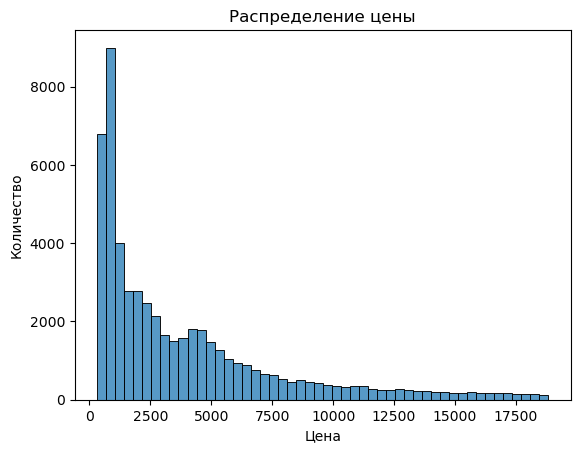

In [7]:
import matplotlib.pyplot as plt

sns.histplot(y, bins=50)
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

In [8]:
low_cost = df[df['price'] < 2500]
len(low_cost) / len(df)

0.5105672969966629

Распределение цен *неравномерно*: ~1/2 таргета - бриллианты ценой до 2500$.

Линейна ли задача? Посмотрим на зависимость таргета от *числовых* признаков

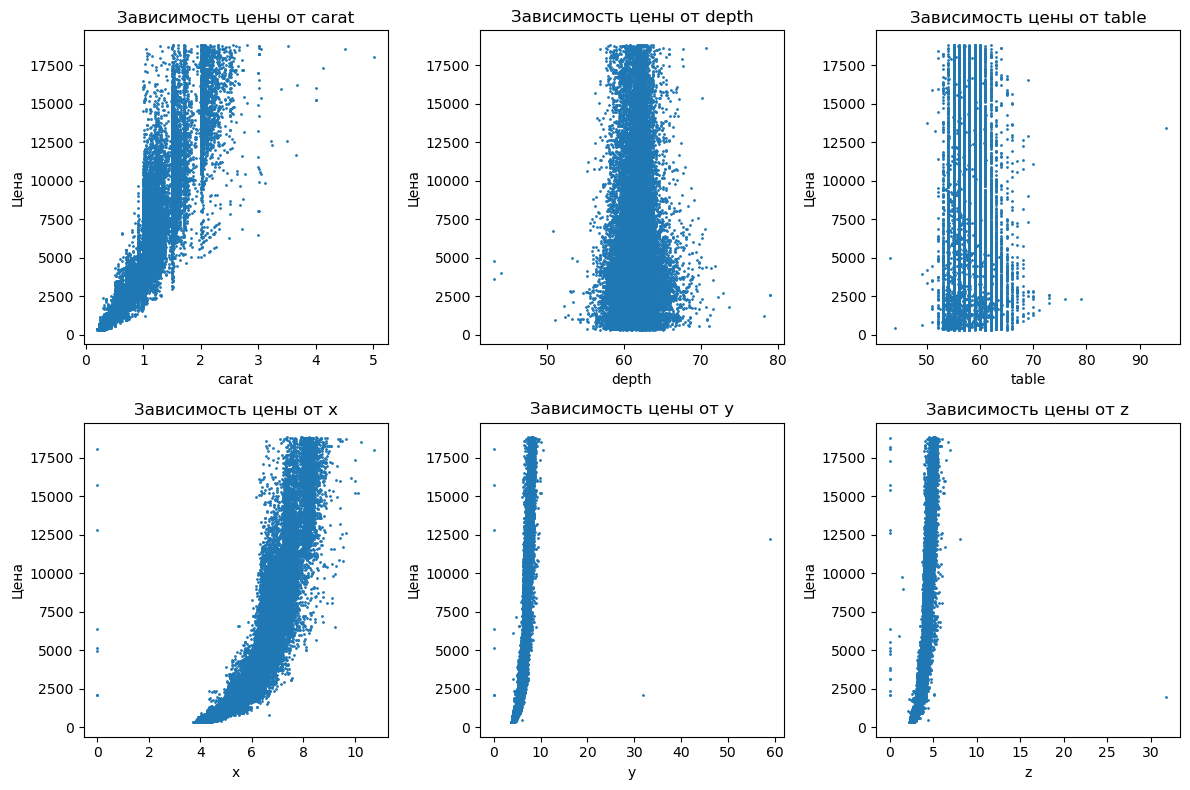

In [9]:
num_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, col in enumerate(num_cols):
    row = i // 3
    col_idx = i % 3
    axs[row, col_idx].scatter(X[col], y, s=1)
    axs[row, col_idx].set_title(f'Зависимость цены от {col}')
    axs[row, col_idx].set_xlabel(col)
    axs[row, col_idx].set_ylabel('Цена')

plt.tight_layout()
plt.show() 

Ни на одном из графиков не видно **линейной зависимости**. Где-то с увеличением признака цена растет по параболе, где-то - экспоненциально. Возможно после некоторых преобразований (получение *полиномиальных* признаков) задача сведется к линейной. Без преобразований линейные модели будут *уступать* нелинейным. Убедимся в этом в нашем опыте.

---

## 2) Линейная модель
Так как в нашем датасете есть *категориальные* признаки, нужно их кодировать. Не забываем и про масштабирование *числовых* признаков. Используем `OneHotEncoder` и `StandardScaler` внутри `Pipeline`.

Числовые признаки уже сохранены в переменной `num_cols`, получим категориальные

In [10]:
cat_cols = ['cut', 'color', 'clarity']

Разобьем на train и test перед преобразованиями, чтобы избежать *утечки данных*

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((43152, 9), (10788, 9))

Кодируем и масштабируем наши данные

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

ridge_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", Ridge())
])

Обучим модель `Ridge` с подбором оптимального гиперпараметра `alpha` через `GridSearchCV` (5-fold)

In [13]:
param_grid = {
    "model__alpha": [0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    ridge_pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_

Насколько хороша наша модель? Напишем функцию для быстрой получения всех нужных нам метрик (RMSE, MAE, R²)

In [54]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

def get_metrics(model, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    rmse_train = root_mean_squared_error(y_train, pred_train)
    rmse_test = root_mean_squared_error(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    r2_test = r2_score(y_test, pred_test)

    columns = ['RMSE train', 'RMSE test', 'MAE test', 'R² test']

    metrics = (
        pd.DataFrame(
            [[rmse_train, rmse_test, mae_test, r2_test]],
            columns=columns
        )
        .round(2)
    )

    return metrics

ridge_metrics = get_metrics(best_ridge, X_train, X_test, y_train, y_test)
ridge_metrics

,RMSE train,RMSE test,MAE test,R² test
0,1128.57,1135.2,737.14,0.92


Как видим, модель имеет высокие *bias* и *variance* разных метрик - признак *недообучения*.

Линейная модель ограничена тем, что предполагает линейную зависимость между признаками и ценой. В задаче стоимости бриллиантов влияние признаков явно нелинейное. Кроме того, one-hot кодирование категорий увеличивает размерность и не позволяет уловить порядковость качества. Улучшить модель можно с помощью *полиномиальных* признаков или более сложных *регуляризованных* линейных моделей.

---

## 3) Decision Tree Regressor
Обучим модель `DecisionTreeRegressor` с подбором гиперпараметров при помощи *поиска по сетке*

In [55]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)

param_grid = {
    "max_depth": [3, 5, 8, 12, 16],
    "min_samples_leaf": [1, 5, 10, 20]
}

grid_tree = GridSearchCV(
    tree,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True).reindex(
    columns=X_train_enc.columns, fill_value=0
)

grid_tree.fit(X_train_enc, y_train)
best_tree = grid_tree.best_estimator_

tree_metrics = get_metrics(best_tree, X_train_enc, X_test_enc, y_train, y_test)
tree_metrics

,RMSE train,RMSE test,MAE test,R² test
0,509.38,639.62,331.04,0.97


In [32]:
grid_tree.best_params_

{'max_depth': 16, 'min_samples_leaf': 10}

Переобучение присутствует: дерево склонно к переобучению - качество на трейне значительно лучше, чем на тесте (RMSE).

Избавиться от переобучения, увеличивая глубину, нельзя. Увеличение глубины наоборот усиливает переобучение, так как дерево начинает запоминать обучающую выборку. Для борьбы нужно ограничивать сложность (max_depth, min_samples_leaf) или использовать *ансамбли*.

---

## 4) Ансамбли
### 4.1) Bagging Regressor
Обучим модель `BaggingRegressor`, подбирая по сетке гиперпараметры `n_estimators`. Что касается гиперпараметра `max_depth`: возьмем лучший показатель с предыдущего пункта. Почему?

Дело в том, что модели *бэггинга* из-за усреднения прогнозов базовых моделей имеют низкий *variance*. Поэтому для бэггинга берут оптимально глубокие деревья, достигая этим низкого *bias*.

In [38]:
from sklearn.ensemble import BaggingRegressor

base_tree = DecisionTreeRegressor(
    max_depth=grid_tree.best_params_["max_depth"],
    random_state=42
)

bagging = BaggingRegressor(
    estimator=base_tree,
    random_state=42,
)

param_grid = {
    "n_estimators": [10, 30, 50]
}

grid_bagging = GridSearchCV(
    bagging,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
)

grid_bagging.fit(X_train_enc, y_train)
best_bagging = grid_bagging.best_estimator_

get_metrics(best_bagging, X_train_enc, X_test_enc, y_train, y_test)

,RMSE train,RMSE test,MAE test,R² test
0,322.79,558.84,284.38,0.98


Как мы видим, бэггинг уменьшил bias и variance модели, поэтому качество улучшилось, но разрыв между train и test увеличился. Это происходит из-за усреднения независимых деревьев.

Дело в том, что бэггинг использует глубокие деревья, имеющие низкий bias и высокий variance. Усредняя их показатели на выходе, модель получает еще меньший bias и чуть меньший variance

### 4.2) Random Forest
Обучим модель `RandomForestRegressor`, подбирая с помощью `RandomizedSearchCV` гиперпараметры `n_estimators`, `max_depth` и `max_features`

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(10, 50),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 11),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_enc, y_train)
best_rf = random_search.best_estimator_

get_metrics(best_rf, X_train_enc, X_test_enc, y_train, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,RMSE train,RMSE test,MAE test,R² test
0,333.64,556.09,278.18,0.98


Random Forest добавляет случайный выбор признаков при каждом сплите, что уменьшает *корреляцию* между деревьями. Этим объясняется чуть более высокий bias модели, но при этом более низкий variance. Случайный выбор признаков снижает *variance* ансамбля и улучшает обобщающую способность. Разрыв при росте глубины увеличивается, так как каждое дерево сильнее переобучается.

### 4.3) CatBoostRegressor
Обучим модель `CatBoostRegressor`, подбирая с помощью `RandomizedSearchCV` гиперпараметры `depth`, `learning_rate` и `iterations`

In [49]:
import numpy as np
from catboost import CatBoostRegressor
from scipy.stats import randint, uniform

cat_features_idx = [X.columns.get_loc(c) for c in cat_cols]

cat = CatBoostRegressor(
    verbose=0,
    random_state=42
)

param_dist = {
    'iterations': randint(200, 1000),
    'depth': randint(4, 9),
    'learning_rate': uniform(0.01, 0.3)
}

random_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_cat.fit(
    X_train,
    y_train,
    cat_features=cat_features_idx
)

best_cat = random_cat.best_estimator_

get_metrics(best_cat, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,RMSE train,RMSE test,MAE test,R² test
0,462.62,522.46,271.32,0.98


In [51]:
best_params = random_cat.best_params_

final_cat = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=0
)

final_cat.fit(
    X_train,
    y_train,
    cat_features=cat_features_idx,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

get_metrics(final_cat, X_train, X_test, y_train, y_test)

,RMSE train,RMSE test,MAE test,R² test
0,463.97,522.28,271.55,0.98


Бустинг выигрывает за счёт последовательного исправления ошибок предыдущих моделей и способности моделировать сложные нелинейные зависимости. Насчет признаков переобучения сказать нечего: по сравнению с Random Forest, сильно увеличился bias, при этом снизился variance. Наоборот, модель **лучше** подстроилась под данные, снизив разрыв между bias и variance. В отличие от bagging, бустинг уменьшает bias, а не только variance.

---

## 5) Итоговое сравнение
Построим таблицу результатов всех моделей

In [64]:
results = pd.concat([
    get_metrics(best_ridge, X_train, X_test, y_train, y_test),
    get_metrics(best_tree, X_train_enc, X_test_enc, y_train, y_test),
    get_metrics(best_bagging, X_train_enc, X_test_enc, y_train, y_test),
    get_metrics(best_rf, X_train_enc, X_test_enc, y_train, y_test),
    get_metrics(best_cat, X_train, X_test, y_train, y_test)
], ignore_index=True)

index_names = ['Ridge', 'DT', 'Bagging', 'RF', 'CB']
results.index = index_names

results.sort_values("RMSE test", inplace=True)

results

,RMSE train,RMSE test,MAE test,R² test
CB,462.62,522.46,271.32,0.98
RF,333.64,556.09,278.18,0.98
Bagging,322.79,558.84,284.38,0.98
DT,509.38,639.62,331.04,0.97
Ridge,1128.57,1135.20,737.14,0.92


1. Лучшая модель - CatBoost. У него наименьшие значения тестовых ошибок: RMSE = 522.46 и MAE = 271.32, а также максимальный R² = 0.98. Это говорит о том, что градиентный бустинг на деревьях лучше всего справился с задачей.

2. Разница между Random Forest и CatBoost невелика, но заметна. RF показывает RMSE test = 556.09, что на ~6% выше, чем у CatBoost, а MAE test = 278.18 — на ~2.5% выше. Обе модели - ансамбли деревьев, но CatBoost использует последовательное исправление ошибок, что позволяет точнее подстроиться под данные, особенно при наличии сложных зависимостей или категориальных признаков.

3. Ridge проигрывает сильнее всего в абсолютных значениях ошибок: её RMSE test более чем в два раза превышает показатель CatBoost, а MAE test почти втрое выше (737 против 271). R² = 0.92 против 0.98 у остальных — это свидетельствует о том, что линейная аппроксимация неспособна уловить реальную структуру данных.

4. Ключевую роль в задаче играют нелинейность и ансамблирование. Дерево решений уже учитывает нелинейные эффекты и даёт значительное улучшение по сравнению с линейной моделью (RMSE test 639 против 1135). Однако одиночное дерево сильно переобучается (разрыв train-test 509-639). Применение бэггинга снижает variance и улучшает тестовую ошибку до 558, а случайный лес и CatBoost дополнительно повышают качество за счёт случайного отбора признаков и бустинга. Таким образом, без учёта нелинейностей результат был бы плохим, а ансамблирование позволяет раскрыть потенциал деревьев, уменьшая переобучение и улучшая обобщающую способность. Взаимодействия признаков также важны, так как деревья автоматически их моделируют, и ансамбли усиливают этот эффект.

